In [70]:
import os
import subprocess

from jacksonii_analyses import vcf_parser, clustering

os.makedirs("../data/phylo", exist_ok=True)

base_alignment = "../data/phylo/snp_concat.fasta"
cleaned_alignment = "../data/phylo/snp_concat.fasta.varsites.phy"
def iqtree_cmd(fasta_path):
    return [
        "iqtree",
        "-s", fasta_path,
        "-m", "GTR+G+ASC",
        "-bb", "1000",
        "-nt", "AUTO",
    ]

groups = [
    'A. jacksonii', 
    'A. sp T31', 
    'A. sp jack6', 
    'A. sp jack5',
    'A. sp jack3', 
    'A. sp jack2', 
    'A. sp jack1', 
    'A. sp F11',
]

palette = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
]

map_colors = dict(zip(groups, palette))

In [ ]:
pops = clustering.read_populations(
    "../data/samples/populations.txt",
)
pops["colormap"] = pops["populations_clean"].map(map_colors)

In [2]:
vcf_parser.vcf_to_snp_fasta(
    vcf_path="../data/var/filtered_variants.vcf.gz", 
    output="../data/phylo/snp_concat.fasta",
)

This part of the code 👇 is meant to fail. But it will generate a clean phylip file that we can use in a separate process.

In [6]:
base_run = subprocess.run(iqtree_cmd(base_alignment), capture_output=True, text=True)

print("STDOUT:\n", base_run.stdout)
print("STDERR:\n", base_run.stderr)


STDOUT:
 
******************************************************
CHECKPOINT: Resuming analysis from ../data/phylo/snp_concat.fasta.ckp.gz

IQ-TREE multicore version 2.4.0 for Linux x86 64-bit built Feb 12 2025
Developed by Bui Quang Minh, Nguyen Lam Tung, Olga Chernomor, Heiko Schmidt,
Dominik Schrempf, Michael Woodhams, Ly Trong Nhan, Thomas Wong

Host:    419e319301e8 (AVX2, FMA3, 30 GB RAM)
Command: iqtree -s ../data/phylo/snp_concat.fasta -m GTR+G+ASC -bb 1000 -nt AUTO
Seed:    835944 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Sun Jun 29 23:48:02 2025
Kernel:  AVX+FMA - auto-detect threads (18 CPU cores detected)

Reading alignment file ../data/phylo/snp_concat.fasta ... Fasta format detected
Reading fasta file: done in 0.0096708 secs using 83.39% CPU
Alignment most likely contains DNA/RNA sequences
Alignment has 61 sequences with 27451 columns, 24820 distinct patterns
16683 parsimony-informative, 6378 singleton sites, 4390 constant sites
             Gap/Am

In [7]:
result = subprocess.run(iqtree_cmd(cleaned_alignment), capture_output=True, text=True)

print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

STDOUT:
 
******************************************************
CHECKPOINT: Resuming analysis from ../data/phylo/snp_concat.fasta.varsites.phy.ckp.gz

IQ-TREE multicore version 2.4.0 for Linux x86 64-bit built Feb 12 2025
Developed by Bui Quang Minh, Nguyen Lam Tung, Olga Chernomor, Heiko Schmidt,
Dominik Schrempf, Michael Woodhams, Ly Trong Nhan, Thomas Wong

Host:    419e319301e8 (AVX2, FMA3, 30 GB RAM)
Command: iqtree -s ../data/phylo/snp_concat.fasta.varsites.phy -m GTR+G+ASC -bb 1000 -nt AUTO
Seed:    724478 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Sun Jun 29 23:48:11 2025
Kernel:  AVX+FMA - auto-detect threads (18 CPU cores detected)

Reading alignment file ../data/phylo/snp_concat.fasta.varsites.phy ... Phylip format detected
Alignment most likely contains DNA/RNA sequences
Alignment has 61 sequences with 23061 columns, 20699 distinct patterns
16683 parsimony-informative, 6378 singleton sites, 0 constant sites
             Gap/Ambiguity  Composition  p

In [129]:
import warnings
from ete3 import Tree, TreeStyle, NodeStyle, TextFace
from IPython.display import Image, display

warnings.filterwarnings("ignore", category=UserWarning, module="ete3")

treefile = "../data/phylo/snp_concat.fasta.varsites.phy.treefile"
t = Tree(treefile, format=1)
t.set_outgroup(t.get_midpoint_outgroup())
t.ladderize(direction=1)

tb = t.copy()

for node in t.traverse():
    nstyle = NodeStyle()
    nstyle["size"] = 0  # Hide node circles
    nstyle["hz_line_width"] = 3  # Increase horizontal line width
    nstyle["vt_line_width"] = 3  # Increase vertical line width
    if node.is_leaf():
        color = pops.loc[node.name, "colormap"]
        node.add_face(
            TextFace(
                node.name, 
                fsize=8, 
                fgcolor=color, 
                ftype="Sans",
                fstyle="italic", 
                bold=False,
            ), 
        column=0,
    )
    node.set_style(nstyle)

for node in tb.traverse():
    nstyle = NodeStyle()
    nstyle["size"] = 0  # Hide node circles
    nstyle["hz_line_width"] = 3  # Increase horizontal line width
    nstyle["vt_line_width"] = 3  # Increase vertical line width
    if node.is_leaf():
        node.add_face(
            TextFace(
                node.name, 
                fsize=8, 
                fgcolor="Black", 
                ftype="Sans",
                fstyle="italic", 
                bold=False,
            ), 
        column=0,
    )
    node.set_style(nstyle)

for pop, color in map_colors.items():
    samples = list(pops[pops["populations_clean"] == pop].index)
    clade_node = t.get_common_ancestor(samples)
    clade_node.add_face(
        TextFace(pop, fsize=8, fgcolor=color, ftype="Sans", bold=False),
        column=0,
        position="branch-top"
    )

ts = TreeStyle()
ts.show_leaf_name = False
ts.scale = 4000
ts.show_scale = True

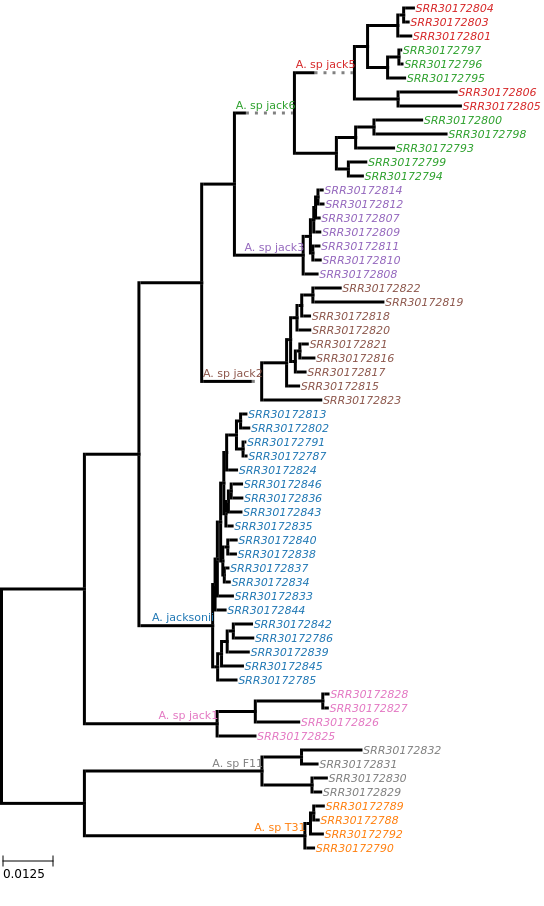

In [131]:
tb.render("../data/phylo/concat-tree-black.svg", tree_style=ts)
t.render("../data/phylo/concat-tree-display.png", tree_style=ts)
display(Image(filename="../data/phylo/concat-tree-display.png"))
